# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [339]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [340]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [9]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
IP = "172.26.3.35"
port = 443
url = f"http://{IP}:{port}"

design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
stl_tess = Tesseract.from_url(url)
# stt_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [10]:
Nx, Ny, Nz = 250, 200, 20
Lx, Ly, Lz = 50, 40, 4

grid_fin_params = {
    "angular_positions": jnp.array(
        [
            [0, 3.14],
            [0.39, 3.53],
            [0.79, 3.93],
            [1.18, 4.32],
            [1.57, 4.71],
            [1.96, 5.11],
            [2.36, 5.50],
            [2.75, 5.89],
        ]
    ),
    "plane_height": 800,
    "plane_thickness": 100,
    "cuttin_plane_1": 400,
    "cuttin_plane_2": 400,
}

# lets create a flat parameter array from the grid fin params
init_diffable_paramas = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        grid_fin_params["angular_positions"].flatten(),
    ]
)

non_diffable_paramas = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_paramas,
    "static_parameters": jnp.array([], dtype=jnp.int32),
    "string_parameters": [
        "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe",
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": TesseractReference(stl_tess),
    "grid_center": [0.0, 0.0, 2.0],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": init_diffable_paramas,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

RuntimeError: Traceback (most recent call last):
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 664, in run_tesseract
    result = self._endpoints[endpoint](parsed_payload)
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/runtime/core.py", line 155, in apply
    out = api_module.apply(payload.inputs)
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/sdf_fd_tess/tesseract_api.py", line 245, in apply
    sdf, mesh = geometries_and_sdf(
                ~~~~~~~~~~~~~~~~~~^
        target=inputs.mesh_tesseract,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<7 lines>...
        grid_center=inputs.grid_center,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/sdf_fd_tess/tesseract_api.py", line 208, in geometries_and_sdf
    geos = get_geometries(
        target=target,
    ...<3 lines>...
        string_parameters=string_parameters,
    )
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/sdf_fd_tess/tesseract_api.py", line 123, in get_geometries
    meshes = target.apply(
             ~~~~~~~~~~~~^
        {
        ^
    ...<4 lines>...
        }
        ^
    )["meshes"]
    ^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
    return func(self, *args, **kwargs)
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 325, in apply
    return self._client.run_tesseract("apply", payload, run_id)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 619, in run_tesseract
    return self._request(endpoint, method, payload, run_id)
           ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 569, in _request
    raise ValidationError.from_exception_data(
        f"endpoint {endpoint}", line_errors=errors
    )
pydantic_core._pydantic_core.ValidationError: 3 validation errors for endpoint apply
body.inputs.non_differentiable_parameters.`chain[EncodedArrayModel__any__float32__noflags,function-plain[functools.partial(<function decode_array at 0x00000295F1882F20>, expected_shape=(None,), expected_dtype='float32')()]]`
  Input should be a valid dictionary or object to extract fields from [type=model_attributes_type, input_value=[{'shape': [2], 'dtype': ... 'encoding': 'base64'}}], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/model_attributes_type
body.inputs.non_differentiable_parameters.`function-plain[functools.partial(<function python_to_array at 0x00000295F1882E80>, expected_shape=(None,), expected_dtype='float32')()]`
  Value error, Could not convert object to numeric NumPy array (got dtype: object) [type=value_error, input_value=[{'shape': [2], 'dtype': ... 'encoding': 'base64'}}], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error
body.inputs.static_parameters
  Extra inputs are not permitted [type=extra_forbidden, input_value=[[]], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden

Error running Tesseract API apply: 3 validation errors for endpoint apply
body.inputs.non_differentiable_parameters.`chain[EncodedArrayModel__any__float32__noflags,function-plain[functools.partial(<function decode_array at 0x00000295F1882F20>, expected_shape=(None,), expected_dtype='float32')()]]`
  Input should be a valid dictionary or object to extract fields from [type=model_attributes_type, input_value=[{'shape': [2], 'dtype': ... 'encoding': 'base64'}}], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/model_attributes_type
body.inputs.non_differentiable_parameters.`function-plain[functools.partial(<function python_to_array at 0x00000295F1882E80>, expected_shape=(None,), expected_dtype='float32')()]`
  Value error, Could not convert object to numeric NumPy array (got dtype: object) [type=value_error, input_value=[{'shape': [2], 'dtype': ... 'encoding': 'base64'}}], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error
body.inputs.static_parameters
  Extra inputs are not permitted [type=extra_forbidden, input_value=[[]], input_type=list]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden (see above for full traceback)

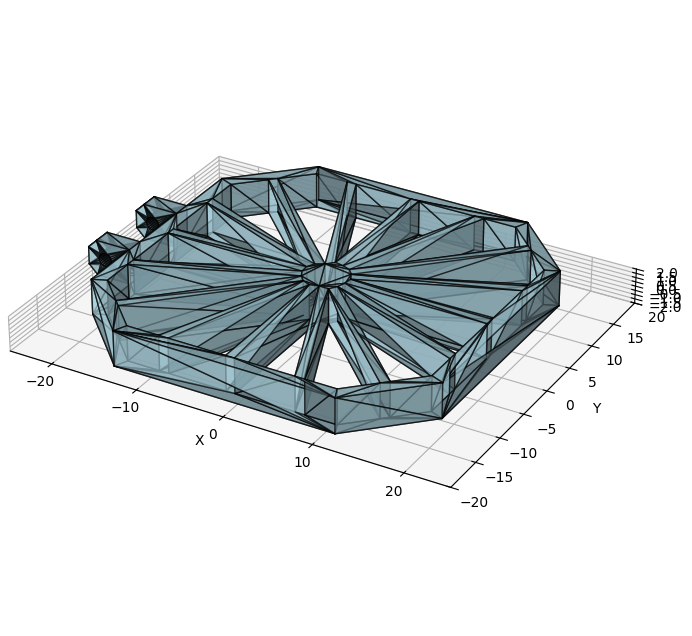

In [80]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # set equal aspect ratio
    ax.set_box_aspect(
        (
            (Lx) / (Ly),
            1,
            (Lz) / (Ly),
        )
    )

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

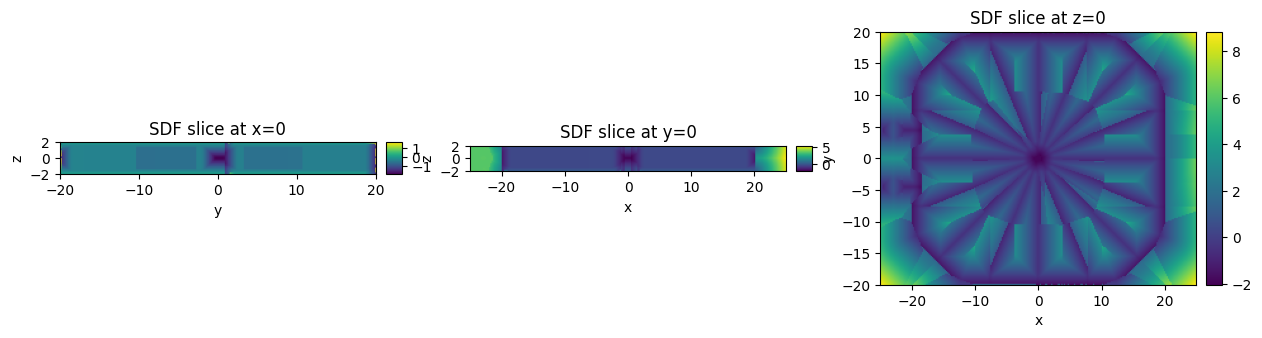

In [81]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

rho min: 0.0009377688984386623, rho max: 0.8489726781845093


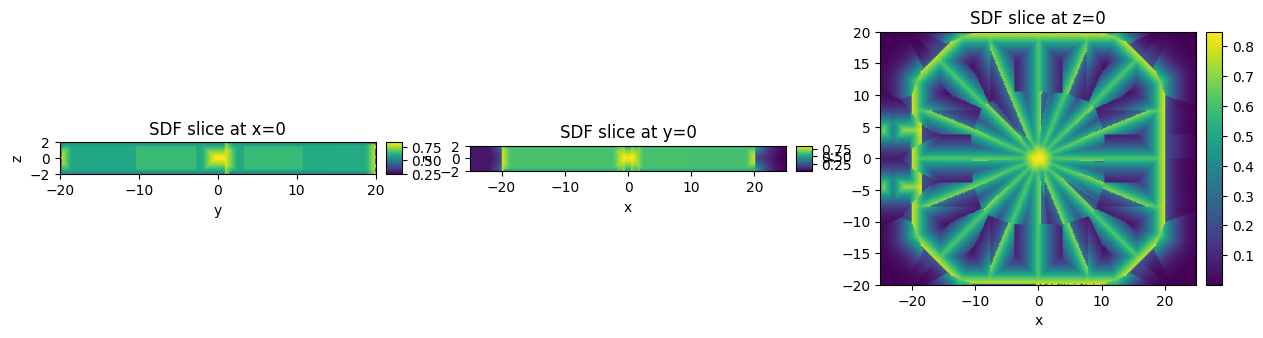

In [87]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 0.8

rho = sdf_to_rho(sdf, scale=rho_scale)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.78125, max: 6.25


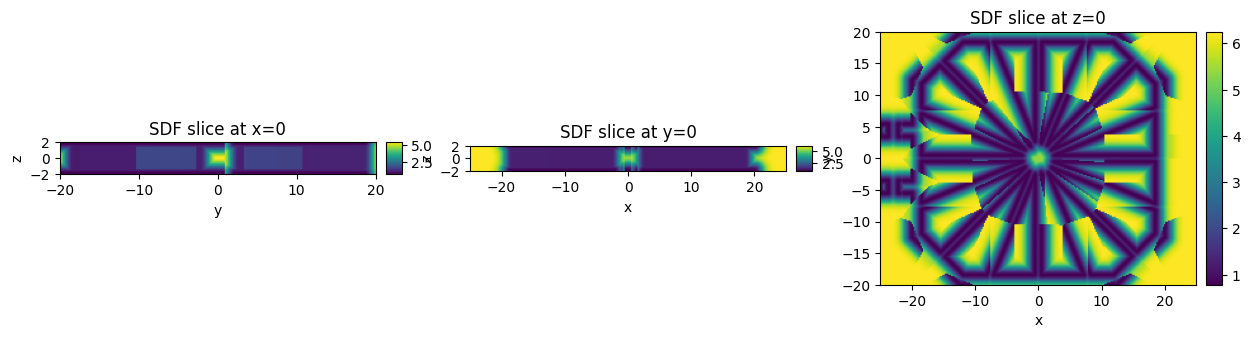

In [88]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 64
sizing_max = Lx / 8
sizing_scale = 1

sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

In [89]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        # "sizing_field": jnp.ones_like(sdf) * (Lx / 10),
        "field_values": rho,
        "max_subdivision_levels": 5,
        "max_points": 40000,
        "max_cells": 40000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

Mesh points: 4894, Mesh faces: 3648


In [90]:
# Lets export it to a .vtk using pyvista


def hex_to_pyvista(pts: np.ndarray, faces: np.ndarray) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    return pv.UnstructuredGrid(cells, cell_types, pts)


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"])
cells_np = np.array(adaptive_mesh["faces"])

hex_mesh = hex_to_pyvista(pts_np, cells_np)

print(hex_mesh)

hex_mesh.save("fem_shapeopt_mesh.vtk")

UnstructuredGrid (0x7de59d95c340)
  N Cells:    40000
  N Points:   40000
  X Bounds:   -2.500e+01, 2.500e+01
  Y Bounds:   -2.000e+01, 2.000e+01
  Z Bounds:   -2.000e+00, 2.000e+00
  N Arrays:   0


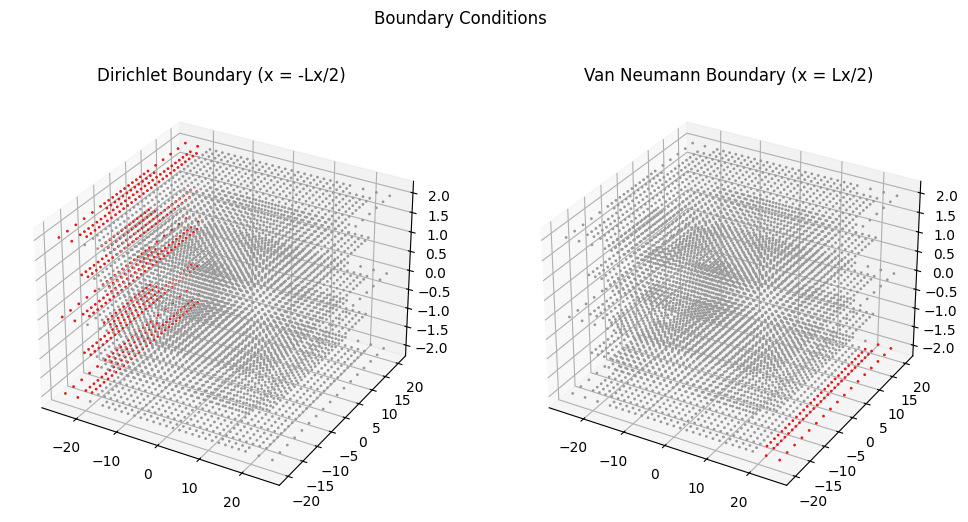

In [91]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 10
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lx / 10),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 10),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

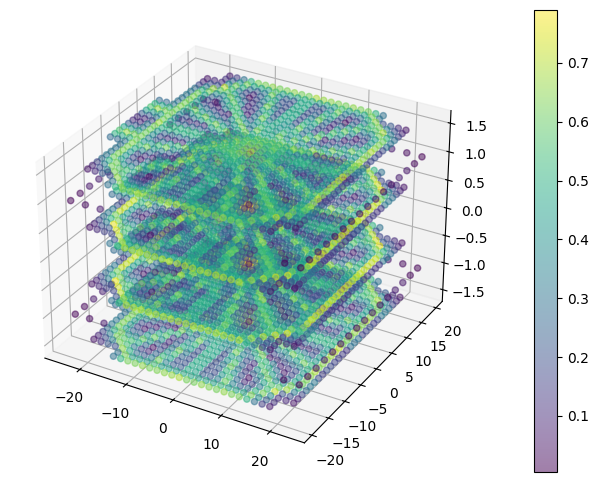

In [92]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [93]:
fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [94]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-08 17:34:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 17:34:20][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 17:34:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-08 17:34:20][DEBUG] jax_fem: Done pre-computations, took 0.6130108833312988 [s]
[11-08 17:34:20][INFO] jax_fem: Solving a problem with 3648 cells, 4894x3 = 14682 dofs.
[11-08 17:34:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 17:34:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 17:34:21][DEBUG] jax_fem: Start timing
[11-08 17:34:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 17:34:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.3136 seconds
[11-08 17:34:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 17:34:21][DEBUG] jax_fem: Before, l_2 res = 251.45299198405732, relative l_2 res = 1.0
[11-08 17:34:21][DEBUG] jax_fem: Solving linear system...
[11-08 17:34:21][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-08 17:34:22][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.7787771590209858e-08
[11-08 17:34:22][DEBUG]

Compliance: 79615.0781


In [95]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)


def loss(
    cell_values: jnp.ndarray,
    mesh: dict,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        cell_values: Material density values for each mesh cell.
        mesh: Mesh dictionary.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    mesh = stop_grads_int(mesh)

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": cell_values,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [96]:
# get the gradient of the loss w.r.t. rho
grad_loss = jax.grad(loss)
grad = grad_loss(
    jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1), adaptive_mesh
)
print("Grad shape:", grad.shape)

[11-08 17:34:23][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 17:34:23][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 17:34:23][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-08 17:34:23][DEBUG] jax_fem: Done pre-computations, took 0.6157491207122803 [s]
[11-08 17:34:23][INFO] jax_fem: Solving a problem with 3648 cells, 4894x3 = 14682 dofs.
[11-08 17:34:23][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 17:34:23][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 17:34:23][DEBUG] jax_fem: Start timing
[11-08 17:34:23][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 17:34:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.3060 seconds
[11-08 17:34:24][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 17:34:24][DEBUG] jax_fem: Before, l_2 res = 100.58119679362294, relative l_2 res = 1.0
[11-08 17:34:24][DEBUG] jax_fem: Solving linear system...
[11-08 17:34:24][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-08 17:34:25][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.082093062670351e-08
[11-08 17:34:25][DEBUG] 

Grad shape: (40000, 1)


Voxel center points shape: (3648, 3)
3648


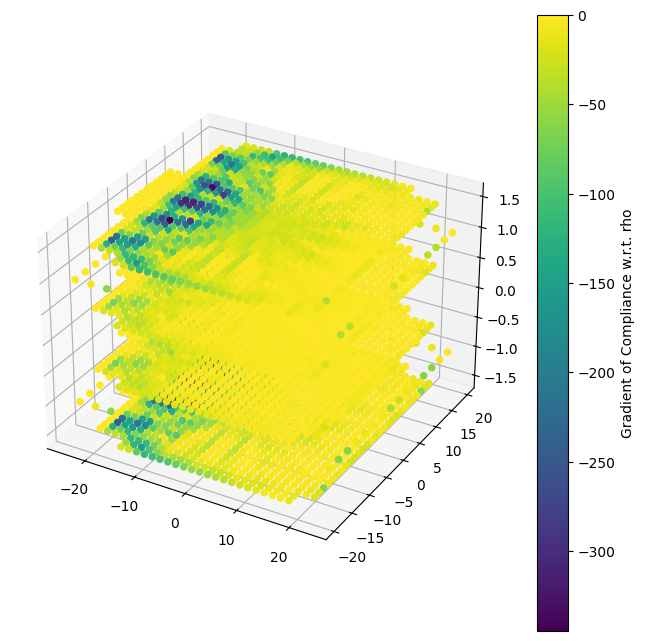

In [97]:
# print a 3D point cloud of the gradient field
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(8, 8))
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
voxel_center_points = jnp.mean(pts_coords[hex_cells], axis=1)
print("Voxel center points shape:", voxel_center_points.shape)
print(mesher_out["mesh"]["n_faces"])
sc = ax.scatter(
    voxel_center_points[:, 0],
    voxel_center_points[:, 1],
    voxel_center_points[:, 2],
    c=grad[: mesher_out["mesh"]["n_faces"], 0],
    cmap="viridis",
    alpha=1.0,
)
# lets add a colorbar
plt.colorbar(sc, ax=ax, label="Gradient of Compliance w.r.t. rho")

In [ ]:
max_points = 9000
max_cells = 9000


def loss(
    rho: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        rho: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 10.0]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [99]:
# get grads of loss w.r.t. rho
grad_loss = jax.grad(loss)
print(rho.shape)
grad = grad_loss(rho)

(250, 200, 20)


[11-08 17:34:31][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 17:34:31][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 17:34:31][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-08 17:34:32][DEBUG] jax_fem: Done pre-computations, took 0.6339199542999268 [s]
[11-08 17:34:32][INFO] jax_fem: Solving a problem with 3648 cells, 4894x3 = 14682 dofs.
[11-08 17:34:32][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 17:34:32][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 17:34:32][DEBUG] jax_fem: Start timing
[11-08 17:34:32][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 17:34:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.3381 seconds
[11-08 17:34:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 17:34:33][DEBUG] jax_fem: Before, l_2 res = 251.45299198405732, relative l_2 res = 1.0
[11-08 17:34:33][DEBUG] jax_fem: Solving linear system...
[11-08 17:34:33][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-08 17:34:34][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.7787771590209858e-08
[11-08 17:34:34][DEBUG]

Grad min: -2154.365 Grad max: -0.0


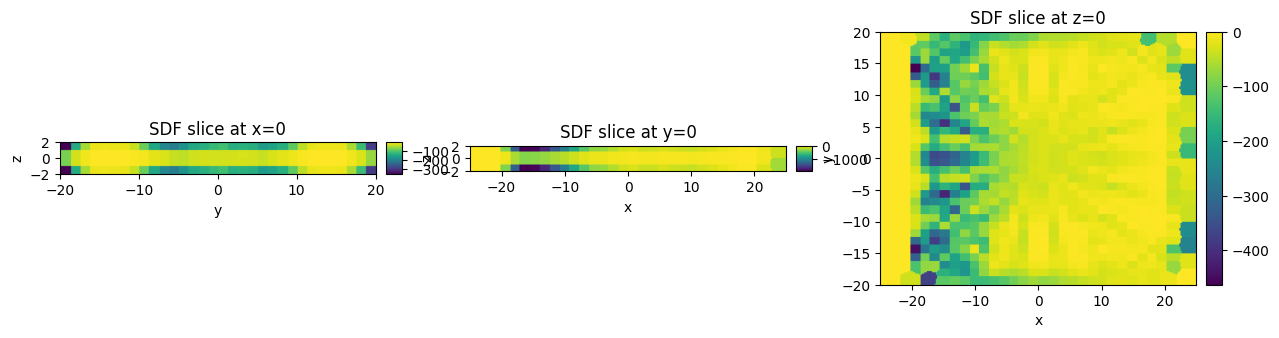

In [101]:
# plot the grad field
plot_grid(grad, Lx, Ly, Lz, Nx, Ny, Nz)
print("Grad min:", jnp.min(grad), "Grad max:", jnp.max(grad))

In [103]:
max_points = 9000
max_cells = 9000


def loss(
    params: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    sdf = design_tess.apply(
        {
            "differentiable_parameters": params,
            **design_inputs,
        }
    )["sdf"]

    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [ ]:
grad_loss = jax.grad(loss)
print(rho.shape)
grad = grad_loss(init_diffable_paramas)

(250, 200, 20)


[11-08 17:39:04][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 17:39:04][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 17:39:04][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 17:39:05][DEBUG] jax_fem: Done pre-computations, took 0.6371238231658936 [s]
[11-08 17:39:05][INFO] jax_fem: Solving a problem with 3648 cells, 4894x3 = 14682 dofs.
[11-08 17:39:05][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 17:39:05][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 17:39:05][DEBUG] jax_fem: Start timing
[11-08 17:39:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 17:39:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.3182 seconds
[11-08 17:39:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 17:39:05][DEBUG] jax_fem: Before, l_2 res = 251.45299198405732, relative l_2 r